In [1]:
from IPython.display import display

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from scipy import stats

In [4]:
from sklearn import preprocessing

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.linear_model import LassoCV

In [7]:
house = pd.read_csv('data/house_train.csv')
house.shape

(1460, 81)

In [8]:
house.iloc[:4, :10]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub


In [9]:
"""
Let's find out which columns have missing values, and how many
"""
n_na = house.isnull().sum(axis= 0)

n_na[n_na.isin([n for n in n_na if n > 0])].sort_values(ascending= False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [10]:
house['SalePrice'].describe().round(2)

count      1460.0
mean     180921.2
std       79442.5
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

In [11]:
print('Sale price skewness: {:20.2f}'.format(stats.skew(house['SalePrice'])))
print('The ratio of max to min sale price: {:.2f}'.format(max(house['SalePrice']) / min(house['SalePrice'])))

Sale price skewness:                 1.88
The ratio of max to min sale price: 21.63


In [12]:
pp = np.percentile(house['SalePrice'], q= [0, 25, 50, 75, 90, 95, 99, 100]) # price percentiles 
pp

array([  34900.  ,  129975.  ,  163000.  ,  214000.  ,  278000.  ,
        326100.  ,  442567.01,  755000.  ])

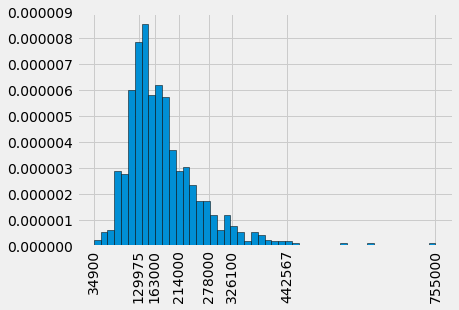

In [13]:
with plt.style.context('fivethirtyeight'):
    plt.hist(house['SalePrice'], bins= 50, density= True,
             edgecolor= 'black')
    plt.xticks(pp, rotation= 90)

In [14]:
m, M = min(house['YearBuilt']), max(house['YearBuilt'])
m, M

(1872, 2010)

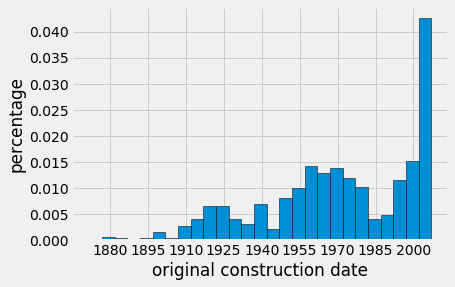

In [15]:
with plt.style.context('fivethirtyeight'):
    plt.hist(house['YearBuilt'], bins= range(m, M+1, 5), density= True,
             edgecolor= 'black')
    plt.xticks(range(1880, 2010, 15))
    plt.xlabel('original construction date')
    plt.ylabel('percentage')

In [16]:
overal_cond = house['OverallCond'].value_counts().sort_index()
overal_cond

1      1
2      5
3     25
4     57
5    821
6    252
7    205
8     72
9     22
Name: OverallCond, dtype: int64

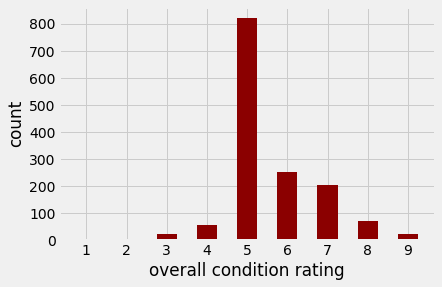

In [17]:
with plt.style.context('fivethirtyeight'):
    plt.bar(overal_cond.index, overal_cond, width= .5, color= 'darkred')
    plt.xlabel('overall condition rating')
    plt.ylabel('count')
    plt.xticks(range(1, 10))

In [18]:
house['LotArea'].describe().round(2)

count      1460.00
mean      10516.83
std        9981.26
min        1300.00
25%        7553.50
50%        9478.50
75%       11601.50
max      215245.00
Name: LotArea, dtype: float64

In [19]:
"""
Here, we see that lot area is heavily skewed;
it's skewness is 12 and the ratio of max to min value is 1665
"""
print('Lot area skewness: {:21.2f}'.format(stats.skew(house['LotArea'])))
print('The ratio of max to min lot area: {:.2f}'.format(max(house['LotArea']) / min(house['LotArea'])))

Lot area skewness:                 12.20
The ratio of max to min lot area: 165.57


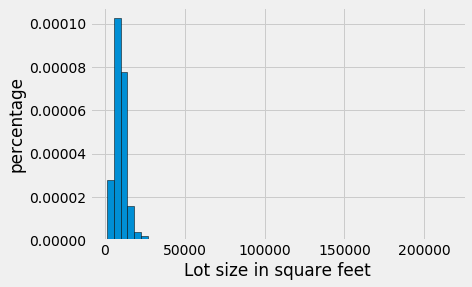

In [20]:
with plt.style.context('fivethirtyeight'):
    plt.hist(house['LotArea'], bins= 50, density= True,
             edgecolor= 'black')
    plt.xlabel('Lot size in square feet')
    plt.ylabel('percentage')

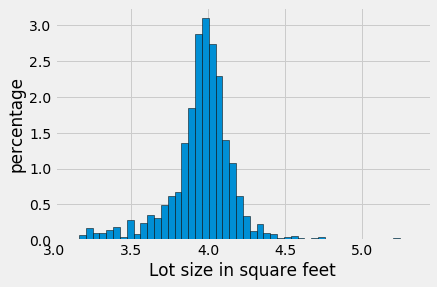

In [21]:
with plt.style.context('fivethirtyeight'):
    plt.hist(np.log10(house['LotArea']), bins= 50, density= True,
             edgecolor= 'black')
    plt.xlabel('Lot size in square feet')
    plt.ylabel('percentage')

In [22]:
"""
Now, the log10 transformation is much more like a well-shaped normal distribution,
in fact, the skewness for the log10 transformation of lot are is close to 0:
"""
print('Lot area, log10 transformation, skewness: {:.2f}'.format(stats.skew(np.log10(house['LotArea']))))

Lot area, log10 transformation, skewness: -0.14


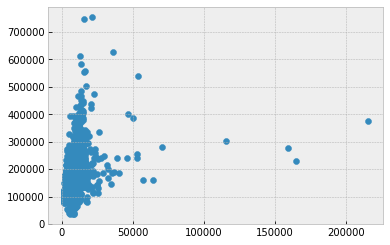

In [23]:
with plt.style.context('bmh'):
    plt.scatter(house['LotArea'], house['SalePrice'])

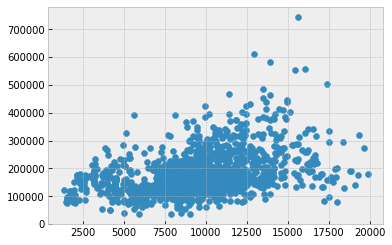

In [24]:
with plt.style.context('bmh'):
    df = house[house['LotArea'] < 2e4]
    plt.scatter(df['LotArea'], df['SalePrice'])

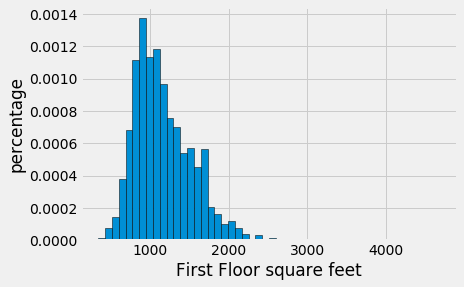

In [25]:
with plt.style.context('fivethirtyeight'):
    plt.hist(house['1stFlrSF'], bins= 50, density= True,
             edgecolor= 'black')
    plt.xlabel('First Floor square feet')
    plt.ylabel('percentage')

In [26]:
print(stats.skew(house['1stFlrSF']))
print(stats.skew(np.log10(house['1stFlrSF'])))

1.3753417421837937
0.079075603383242


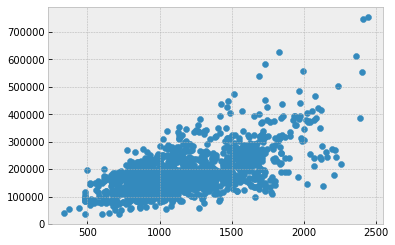

In [27]:
with plt.style.context('bmh'):
    df = house[house['1stFlrSF'] < 2500]
    plt.scatter(df['1stFlrSF'], df['SalePrice'])

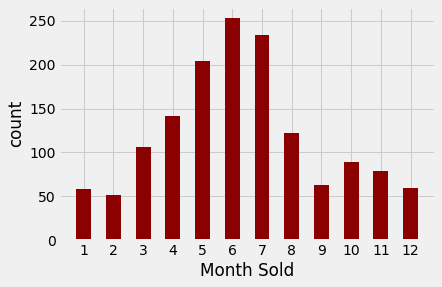

In [28]:
month_sold = house['MoSold'].value_counts().sort_index()

with plt.style.context('fivethirtyeight'):
    plt.bar(month_sold.index, month_sold, width= .5, color= 'darkred')
    plt.xlabel('Month Sold')
    plt.ylabel('count')
    plt.xticks(range(1, 12+1))

In [29]:
house['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [30]:
house[['KitchenQual', 'SalePrice']].groupby('KitchenQual').mean().round(2)

,SalePrice
KitchenQual,
Ex,328554.67
Fa,105565.21
Gd,212116.02
TA,139962.51


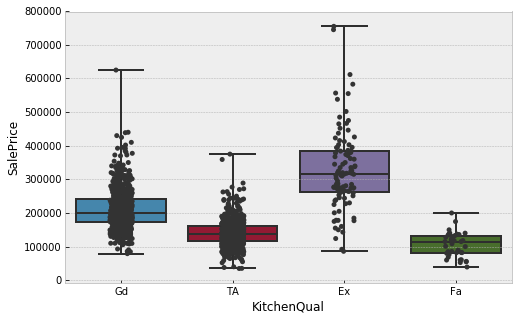

In [31]:
with plt.style.context('bmh'):
    plt.figure(figsize= (8, 5))
    sns.boxplot(x= 'KitchenQual', y= 'SalePrice', data= house,
                whis= np.inf)
    sns.stripplot(x= 'KitchenQual', y= 'SalePrice', data= house,
                  color= '.2', jitter= True)

In [32]:
house['TotRmsAbvGrd'].value_counts().sort_index()

2       1
3      17
4      97
5     275
6     402
7     329
8     187
9      75
10     47
11     18
12     11
14      1
Name: TotRmsAbvGrd, dtype: int64

In [33]:
feature_names = ['TotRmsAbvGrd', 'KitchenQual', 'MoSold', '1stFlrSF', 'LotArea', 'OverallCond', 'YearBuilt']

X = house.loc[:, feature_names].copy()
X.head()

,TotRmsAbvGrd,KitchenQual,MoSold,1stFlrSF,LotArea,OverallCond,YearBuilt
0,8,Gd,2,856,8450,5,2003
1,6,TA,5,1262,9600,8,1976
2,6,Gd,9,920,11250,5,2001
3,7,Gd,2,961,9550,5,1915
4,9,Gd,12,1145,14260,5,2000


In [34]:
le = preprocessing.LabelEncoder()
le.fit(X['KitchenQual'])

LabelEncoder()

In [35]:
le.classes_

array(['Ex', 'Fa', 'Gd', 'TA'], dtype=object)

In [36]:
le.transform(['Ex', 'Fa', 'Gd', 'TA'])

array([0, 1, 2, 3], dtype=int64)

In [37]:
X['KitchenQual'].head()

0    Gd
1    TA
2    Gd
3    Gd
4    Gd
Name: KitchenQual, dtype: object

In [38]:
le.transform(X['KitchenQual'].head())

array([2, 3, 2, 2, 2], dtype=int64)

In [39]:
X['KitchenQual'] = le.transform(X['KitchenQual'])

In [40]:
enc = preprocessing.OneHotEncoder()

In [41]:
y = house['SalePrice']

In [42]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 13962017)